In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [6]:
from pymongo import MongoClient
import json
import urllib.parse

# Load credentials from JSON file
with open('credentials_mongodb.json') as f:
    login = json.load(f)

# Assign credentials to variables
username = login['username']
password = urllib.parse.quote(login['password'])  # Ensure the password is URL encoded
host = login['host']

# Construct the MongoDB connection string
url = f"mongodb+srv://{username}:{password}@{host}/?retryWrites=true&w=majority"

# Connect to MongoDB
client = MongoClient(url)

# Select the database you want to use
db = client['news_database']  # Replace with your database name

# Drop the collection if it exists to free up space
try:
    db.drop_collection('news_collection')  # Replace with the collection name you want to delete
    print("Collection dropped successfully.")
except Exception as e:
    print(f"Error dropping collection: {e}")

# Select the collection you want to use
collection = db['news_collection']  # Replace with your collection name

# Initialize an empty list to store the documents
documents = []

# Load the JSON file
file_path = r"C:\Users\tejaa\Downloads\archive (2)\News_Category_Dataset_v3.json"
with open(file_path, 'r') as file:
    for line in file:
        # Each line is a separate JSON object/document
        documents.append(json.loads(line))

# Number of documents
num_documents = len(documents)
print(f"Total number of documents to insert: {num_documents}")

# Insert the documents into MongoDB
try:
    collection.insert_many(documents)
    print(f"Inserted {num_documents} documents into MongoDB.")
except Exception as e:
    print(f"An error occurred while inserting data: {e}")


Collection dropped successfully.
Total number of documents to insert: 209527
Inserted 209527 documents into MongoDB.


In [8]:
# Fetch all documents from the MongoDB collection
articles = list(collection.find())

# Convert to a pandas DataFrame
df = pd.DataFrame(articles)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   _id                209527 non-null  object
 1   link               209527 non-null  object
 2   headline           209527 non-null  object
 3   category           209527 non-null  object
 4   short_description  209527 non-null  object
 5   authors            209527 non-null  object
 6   date               209527 non-null  object
dtypes: object(7)
memory usage: 11.2+ MB


In [10]:
# Display the first few rows before cleaning
print("Data before cleaning:")
print(df.head())

Data before cleaning:
                        _id  \
0  672046f58761b82b18f64d70   
1  672046f58761b82b18f64d71   
2  672046f58761b82b18f64d72   
3  672046f58761b82b18f64d73   
4  672046f58761b82b18f64d74   

                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_descriptio

In [11]:
#Summary of category column

df['category'].describe()

count       209527
unique          42
top       POLITICS
freq         35602
Name: category, dtype: object

In [12]:
# Check if there is at any duplicate in the DataFrame
has_duplicates = df.duplicated().any()

# Print True if there are duplicates
print(has_duplicates)

False


In [13]:
#Handline missing values
# Display the count of missing values in each column
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])  # Show only columns with missing values


Missing values in each column:
Series([], dtype: int64)


In [ ]:
# # Fill missing 'headline' and 'short_description' with placeholders
# df['headline'] = df['headline'].fillna('Unknown [Missing]')
# df['short_description'] = df['short_description'].fillna('No description available [Missing]')

# # Optionally, drop rows with too many missing values if needed
# df.dropna(subset=['headline', 'short_description'], inplace=True)


In [14]:
#Text Cleaning
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    return text.strip()

# Apply text cleaning function
df['cleaned_headline'] = df['headline'].apply(clean_text)
df['cleaned_short_description'] = df['short_description'].apply(clean_text)


In [15]:
print(df[['headline', 'cleaned_headline', 'short_description', 'cleaned_short_description']].head())


                                            headline  \
0  Over 4 Million Americans Roll Up Sleeves For O...   
1  American Airlines Flyer Charged, Banned For Li...   
2  23 Of The Funniest Tweets About Cats And Dogs ...   
3  The Funniest Tweets From Parents This Week (Se...   
4  Woman Who Called Cops On Black Bird-Watcher Lo...   

                                    cleaned_headline  \
0  over  million americans roll up sleeves for om...   
1  american airlines flyer charged banned for lif...   
2  of the funniest tweets about cats and dogs thi...   
3    the funniest tweets from parents this week sept   
4  woman who called cops on black birdwatcher los...   

                                   short_description  \
0  Health experts said it is too early to predict...   
1  He was subdued by passengers and crew when he ...   
2  "Until you have a dog you don't understand wha...   
3  "Accidentally put grown-up toothpaste on my to...   
4  Amy Cooper accused investment firm Franklin

In [16]:
#Feature engineering
# Add word count and character count features
df['headline_word_count'] = df['cleaned_headline'].apply(lambda x: len(x.split()))
df['description_word_count'] = df['cleaned_short_description'].apply(lambda x: len(x.split()))
df['headline_char_count'] = df['cleaned_headline'].apply(len)
df['description_char_count'] = df['cleaned_short_description'].apply(len)


In [17]:
#Tokenization and Encoding
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize headline and short_description
df['headline_tokens'] = df['cleaned_headline'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
df['description_tokens'] = df['cleaned_short_description'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))


In [18]:
#Label Encoding for Category Column
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

In [19]:
#Data Splitting
# Train-test split with stratification on 'category' if it’s imbalanced
X = df[['cleaned_headline', 'cleaned_short_description', 'headline_tokens', 'description_tokens']]
y = df['category_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


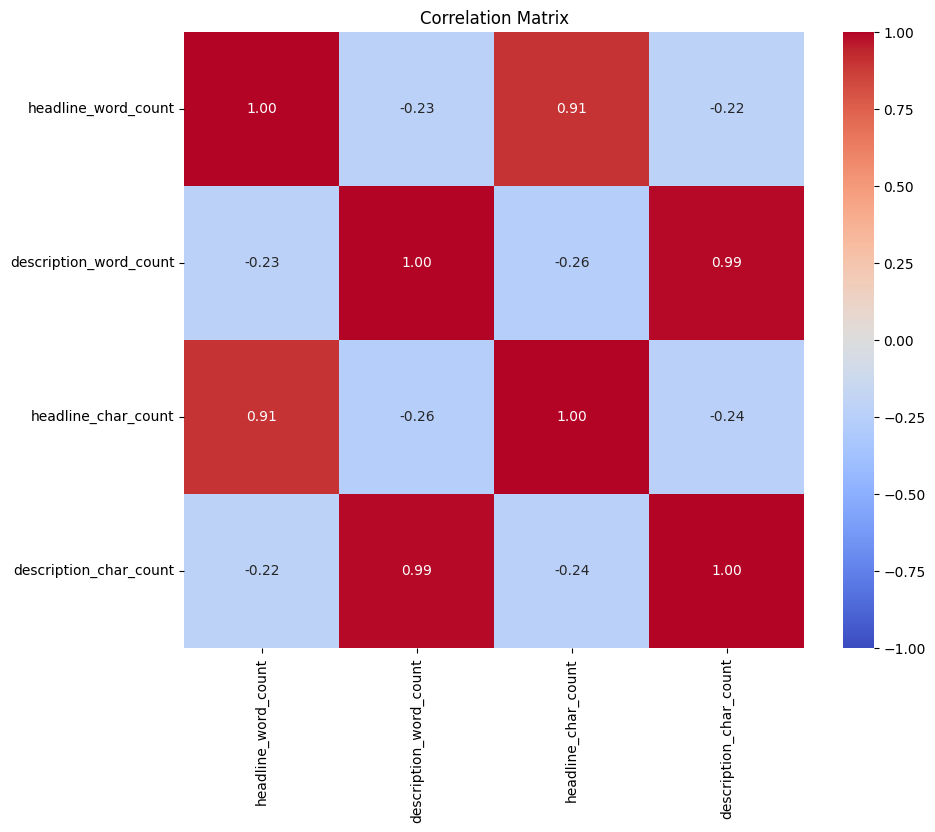

In [23]:
## Calculate and visualize the correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()